In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys

import h5py
import numpy as np
from scipy import stats, interpolate

import powerbox as pbox
import py21cmfast as p21c

WDIR = os.environ['DM21CM_DIR']
sys.path.append(WDIR)
from dm21cm.utils import load_h5_dict

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
mpl.rc_file(f"{WDIR}/matplotlibrc")

/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:59: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:43: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


Default cache dir: /n/netscratch/iaifi_lab/Lab/yitians/dm21cm/21cmFAST-cache


In [4]:
! ls /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc23-250606/log10m2.000

'LightCone_z5.0_HIIDIM=128_BOXLEN=256_fisher_DM_1_r54321.h5'
'LightCone_z5.0_HIIDIM=128_BOXLEN=256_fisher_DM_2_r54321.h5'


In [2]:
outputs_dir = "/n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs"

run0_name = "pbhacc-PRc23-250428"
m0 = 1e2
run1_name = "zero"
m1 = 1

bkg_fn = f"{outputs_dir}/bkg/LightCone_z5.0_HIIDIM=128_BOXLEN=256_fisher_fid_r54321.h5"
fid_fn = f"{outputs_dir}/active/{run0_name}/log10m{np.log10(m0):.3f}/LightCone_z5.0_HIIDIM=128_BOXLEN=256_fisher_DM_2_r54321.h5"
hom_fn = f"{outputs_dir}/active/{run1_name}/log10m{np.log10(m1):.3f}/LightCone_z5.0_HIIDIM=128_BOXLEN=256_fisher_DM_0_r54321.h5"

with h5py.File(bkg_fn, 'r') as hf:
    lcfield_bkg = hf['lightcones']['brightness_temp'][()]
with h5py.File(fid_fn, 'r') as hf:
    lcfield_fid = hf['lightcones']['brightness_temp'][()]
with h5py.File(hom_fn, 'r') as hf:
    lcfield_hom = hf['lightcones']['brightness_temp'][()]
lc_bkg = p21c.LightCone.read(bkg_fn)
z_s = lc_bkg.lightcone_redshifts

In [3]:
EoR_color = mpl.colors.LinearSegmentedColormap.from_list('EoR', [
    (0.0,  'yellow'),
    (0.25, 'orange'),
    (0.5,  'red'),
    (0.75, 'black'),
    (0.85, 'blue'),
    (0.95, 'cyan'),
    (1.0,  'cyan')
])
vmin, vmax = -60, 20 # 0 at 0.75
EoR_color_small = mpl.colors.LinearSegmentedColormap.from_list('EoRsmall', [
    (0.0, 'black'),
    (0.6, 'blue'),
    (1.0, 'cyan')
])

In [4]:
limits_dir = "../outputs/limits"

def get_multiplier(channel, mass):
    mass_s, inj_s, sigma_s = np.loadtxt(f"{limits_dir}/{channel}.txt", unpack=True)
    multiplier_s = np.sqrt(stats.chi2.ppf(.9, df=1)) * sigma_s
    return interpolate.interp1d(mass_s, multiplier_s, kind="linear", bounds_error=True)(mass)

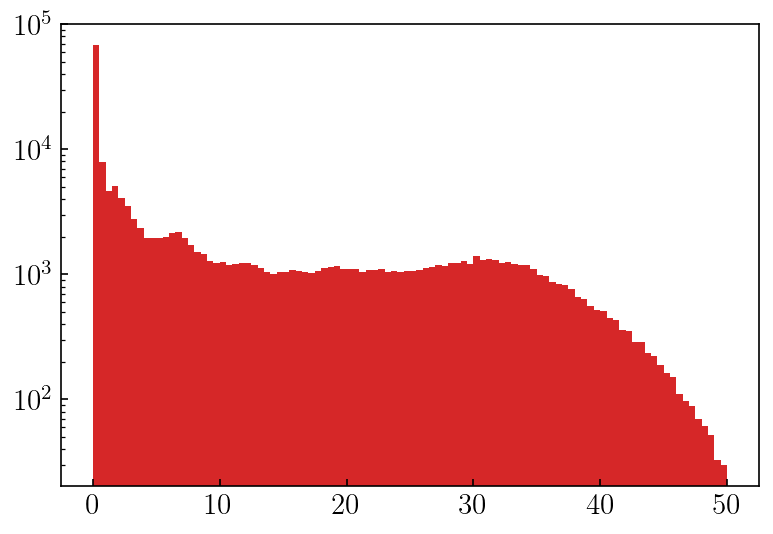

In [28]:
z = ((lcplot_fid - lcplot_bkg) * m).flatten()
plt.hist(z, bins=100, range=(0, 50))
plt.yscale('log');

/tmp/ipykernel_4151768/346497912.py:55: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=0.05, hspace=0.05)


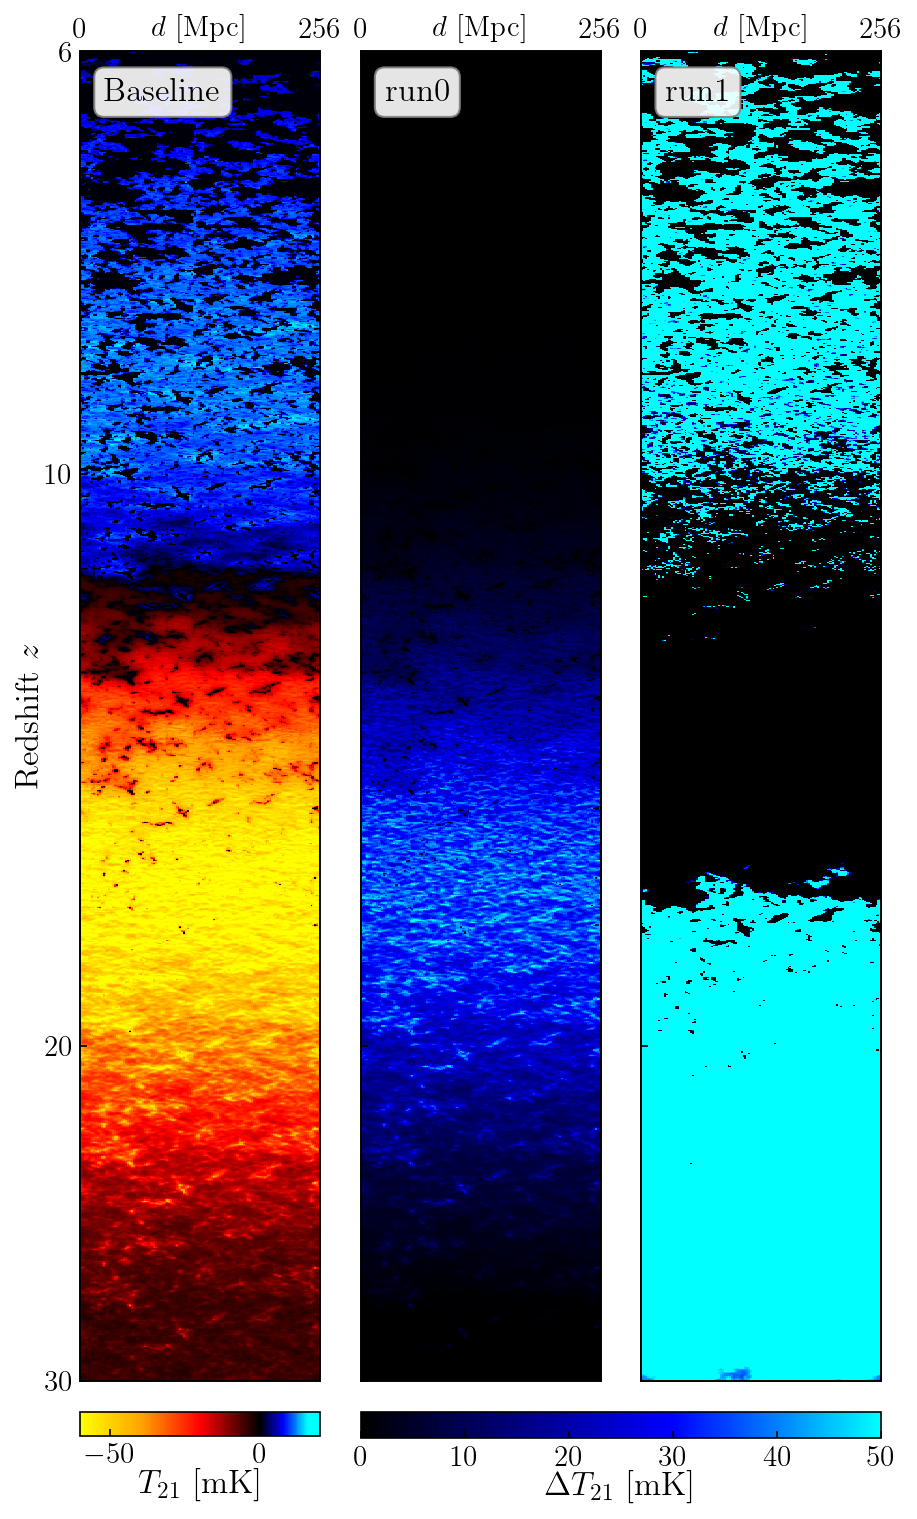

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(6, 10), sharey='row', layout='constrained')

x_s = np.linspace(0, 256, 128)
z_start = 6.
z_end = 30.
i_z_start = np.argmin(np.abs(z_s-z_start)) - 1
i_z_end = np.argmin(np.abs(z_s-z_end)) + 1
z_s_plot = z_s[i_z_start:i_z_end]
lcplot_bkg = lcfield_bkg[:,0,i_z_start:i_z_end].T
lcplot_fid = lcfield_fid[:,0,i_z_start:i_z_end].T
lcplot_hom = lcfield_hom[:,0,i_z_start:i_z_end].T

vmax01 = 50

ax = axs[0]
im = ax.pcolormesh(x_s, z_s_plot, lcplot_bkg, cmap=EoR_color, vmin=vmin, vmax=vmax)
cbar = fig.colorbar(im, ax=ax, aspect=10, pad=0.01, orientation='horizontal')
cbar.ax.set_xlabel(r'$T_{21}$ [mK]', labelpad=0, fontsize=16)

ax = axs[1]
m = get_multiplier(run0_name, m0)
im = ax.pcolormesh(x_s, z_s_plot, (lcplot_fid - lcplot_bkg) * m, cmap=EoR_color_small, vmin=0, vmax=vmax01)

ax = axs[2]
m = get_multiplier(run0_name, m1)
im = ax.pcolormesh(x_s, z_s_plot, (lcplot_hom - lcplot_bkg) * m, cmap=EoR_color_small, vmin=0, vmax=vmax01)
cbar = fig.colorbar(im, ax=axs[1:], aspect=20, pad=0.01, orientation='horizontal')
cbar.ax.set_xlabel(r'$\Delta T_{21}$ [mK]', labelpad=0, fontsize=16)

for ax in axs:
    ax.set(yscale='log', xticks=[])
    axt = ax.twiny()
    axt.set_xticks([0, 256])
    axt.set_xlabel(r'$d$ [Mpc]', labelpad=-9)
    ax.invert_yaxis()

# axs[0].set_title(r'No injection $T_b$ [mK]')
# axs[1].set_title(r'Inhom. injection $T_b-$ No injection $T_b$ [mK]')
# axs[2].set_title(r'Hom. injection $T_b-$ No injection $T_b$ [mK]')

axs[0].set_ylabel('Redshift $z$', labelpad=0, fontsize=16)
axs[0].yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
axs[0].set_yticks([6, 10, 20, 30])
axs[0].set_yticklabels([6, 10, 20, 30])

bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)

axs[0].text(0.1, 0.98, 'Baseline', fontsize=16,
            transform=axs[0].transAxes, ha='left', va='top', bbox=bbox_props)
axs[1].text(0.1, 0.98, 'run0', fontsize=16,
            transform=axs[1].transAxes, ha='left', va='top', bbox=bbox_props)
axs[2].text(0.1, 0.98, 'run1', fontsize=16,
            transform=axs[2].transAxes, ha='left', va='top', bbox=bbox_props)

fig.subplots_adjust(wspace=0.05, hspace=0.05)
#fig.savefig("lightconeexample_delta.png", dpi=300)

/tmp/ipykernel_4151768/976965663.py:55: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=0.05, hspace=0.05)


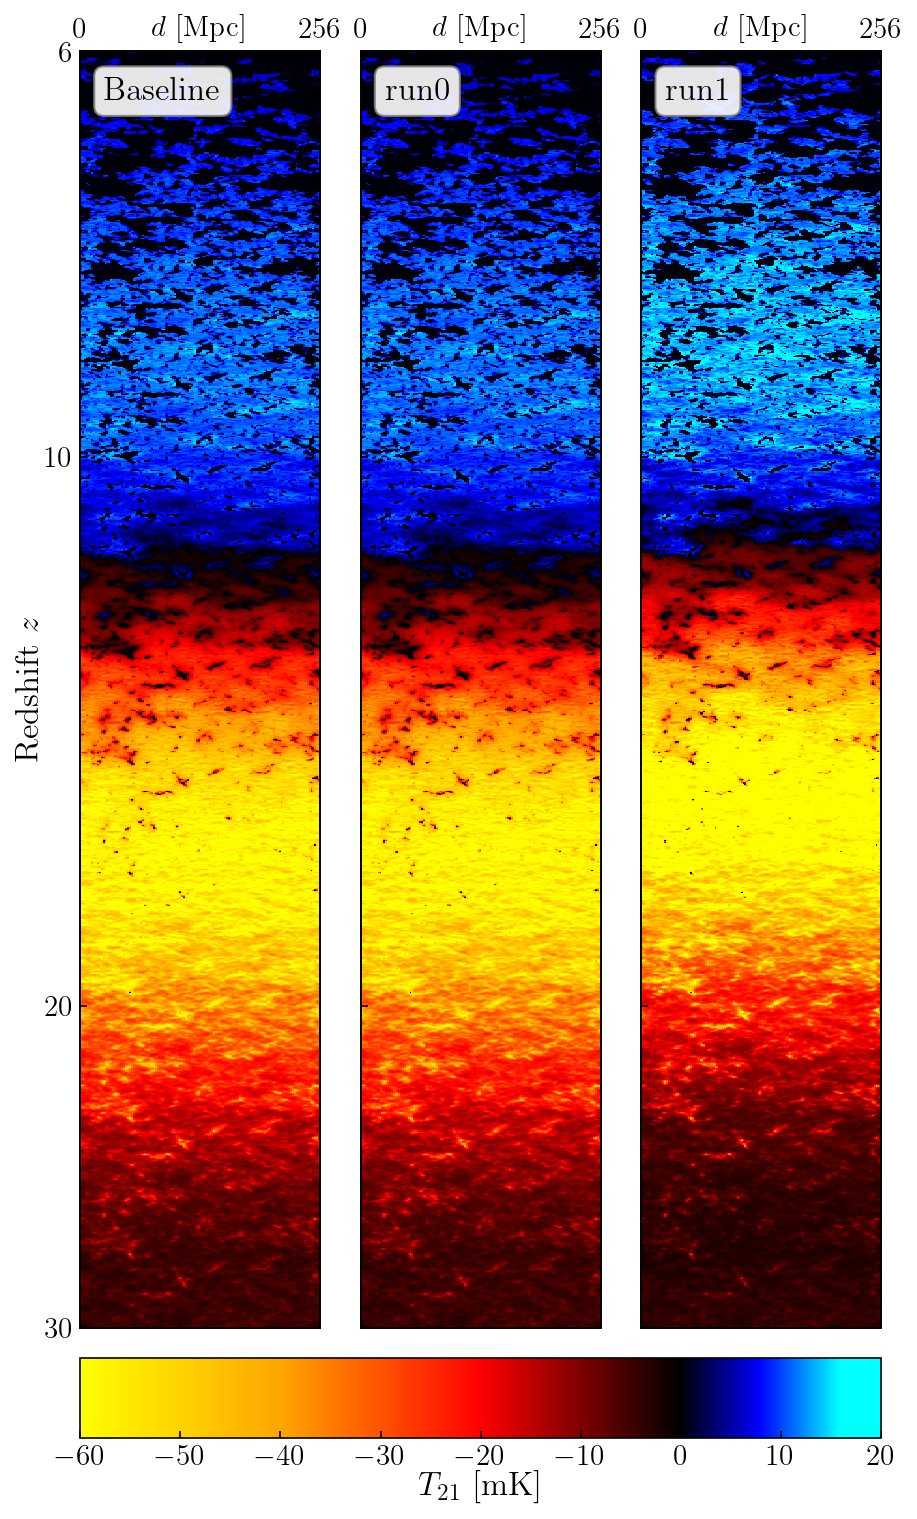

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(6, 10), sharey='row', layout='constrained')

x_s = np.linspace(0, 256, 128)
z_start = 6.
z_end = 30.
i_z_start = np.argmin(np.abs(z_s-z_start)) - 1
i_z_end = np.argmin(np.abs(z_s-z_end)) + 1
z_s_plot = z_s[i_z_start:i_z_end]
lcplot_bkg = lcfield_bkg[:,0,i_z_start:i_z_end].T
lcplot_fid = lcfield_fid[:,0,i_z_start:i_z_end].T
lcplot_hom = lcfield_hom[:,0,i_z_start:i_z_end].T

vmax01 = 50

ax = axs[0]
im = ax.pcolormesh(x_s, z_s_plot, lcplot_bkg, cmap=EoR_color, vmin=vmin, vmax=vmax)
cbar = fig.colorbar(im, ax=axs, aspect=10, pad=0.01, orientation='horizontal')
cbar.ax.set_xlabel(r'$T_{21}$ [mK]', labelpad=0, fontsize=16)

ax = axs[1]
m = get_multiplier(run0_name, m0)
m = 1
im = ax.pcolormesh(x_s, z_s_plot, lcplot_bkg + (lcplot_fid-lcplot_bkg)*m, cmap=EoR_color, vmin=vmin, vmax=vmax)

ax = axs[2]
m = get_multiplier(run0_name, m1)
m = 1
im = ax.pcolormesh(x_s, z_s_plot, lcplot_bkg + (lcplot_hom-lcplot_bkg)*m, cmap=EoR_color, vmin=vmin, vmax=vmax)

for ax in axs:
    ax.set(yscale='log', xticks=[])
    axt = ax.twiny()
    axt.set_xticks([0, 256])
    axt.set_xlabel(r'$d$ [Mpc]', labelpad=-9)
    ax.invert_yaxis()

# axs[0].set_title(r'No injection $T_b$ [mK]')
# axs[1].set_title(r'Inhom. injection $T_b-$ No injection $T_b$ [mK]')
# axs[2].set_title(r'Hom. injection $T_b-$ No injection $T_b$ [mK]')

axs[0].set_ylabel('Redshift $z$', labelpad=0, fontsize=16)
axs[0].yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
axs[0].set_yticks([6, 10, 20, 30])
axs[0].set_yticklabels([6, 10, 20, 30])

bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)

axs[0].text(0.1, 0.98, 'Baseline', fontsize=16,
            transform=axs[0].transAxes, ha='left', va='top', bbox=bbox_props)
axs[1].text(0.1, 0.98, 'run0', fontsize=16,
            transform=axs[1].transAxes, ha='left', va='top', bbox=bbox_props)
axs[2].text(0.1, 0.98, 'run1', fontsize=16,
            transform=axs[2].transAxes, ha='left', va='top', bbox=bbox_props)

fig.subplots_adjust(wspace=0.05, hspace=0.05)
#fig.savefig("lightconeexample_delta.png", dpi=300)

# check injection power

In [16]:
table_old = load_h5_dict("/n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/data/zf002/data/archive/halomod-2.1.0-data/pbhacc_rates/PRc23/PRc23_log10m2.000_cosmo.h5")
table_new = load_h5_dict("/n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/data/zf002/data/pbhacc_rates/PRc23/PRc23_log10m2.000_cosmo.h5")

In [19]:
table_old['shapes']

'ps_cond: (z, cinf, d). ps, st: (zfull, cinf).'

In [20]:
table_new['shapes']

'ps_cond: (z, cinf, d, vcb). ps, st: (zfull, cinf).'

In [23]:
table_old['ps_cond'].shape

(300, 128, 300)

In [31]:
print(np.argmin(np.abs(table_old['d'])))
print(np.argmin(np.abs(table_new['dsub'])))

115


KeyError: 'dsub'

In [24]:
table_new['ps_cond'].shape

(300, 64, 64, 128)

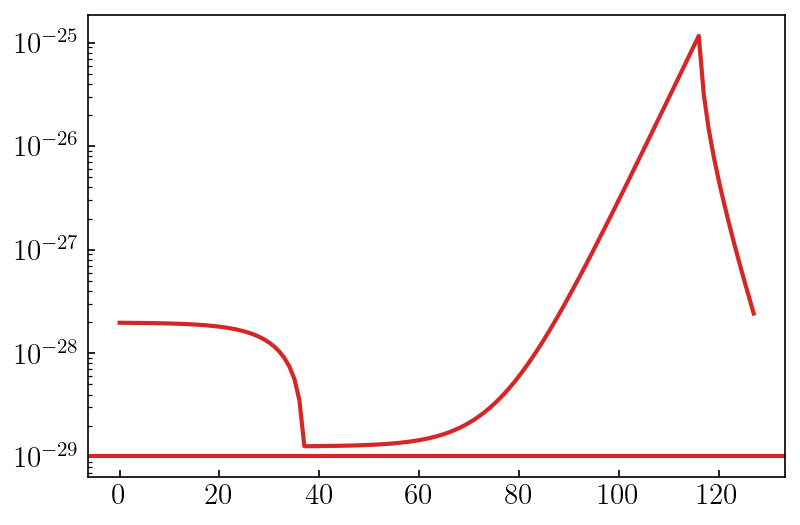

In [26]:
plt.plot(table_new['ps_cond'][150, 32, 32])
plt.axhline(table_old['ps_cond'][150, 64, 150])
plt.yscale('log')